In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from path import Path
from shutil import copy
from Bio import SeqIO, AlignIO, Phylo

In [2]:
import numpy as np

In [3]:
isnvs = pd.read_csv("/Users/al/Documents/scripps/data/all_variants_18112020.csv")
cols = ['sample', 'POS', 'REF', 'ALT', 'ALT_FREQ', 'ALT_AA']
meta = pd.read_csv("../../HCoV-19-Genomics/metadata.csv")
meta_cols = ['ID', 'collection_date', 'location']

meta = meta[meta_cols]
isnvs = isnvs[cols]
isnvs


isnvs['sample'] = isnvs['sample'].astype(str)
isnvs['id_flag'] = False
isnvs.loc[isnvs['sample'].str.contains("SEARCH"), 'id_flag'] = True
def clean_ids(x):
    if x['id_flag']==True:
        s = x["sample"]
        strt = s.find("SEARCH")
        x["sample"] = s[strt+6: strt+10]
    return x 
isnvs["sample"] = isnvs.apply(clean_ids, axis=1)

isnvs = isnvs[isnvs["sample"].str.isdigit()]
isnvs["sample"] = isnvs["sample"].astype(int)
# isnvs

/Users/al/anaconda3/envs/scripps/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (13,19,30,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:

isnvs['sample'].unique().shape

(3833,)

In [5]:
meta.columns

Index(['ID', 'collection_date', 'location'], dtype='object')

In [6]:
meta = meta[meta['ID'].str.contains('SEARCH')]
# meta["ID"]

In [7]:
meta["sample"] = meta["ID"].apply(lambda x: int(x.split('-')[1]))
isnvs = pd.merge(isnvs, meta, on="sample")
isnvs['sample'].unique().shape

(2568,)

In [8]:
isnvs['var'] = isnvs['POS'].astype(str) + ":" + isnvs['ALT']

In [9]:
isnvs = isnvs[isnvs['ALT_FREQ'] > 0.03]

In [10]:
def encode_variable(values):
    variable2idx = {}
    idx2variable = {}
    for idx, var in enumerate(values):
        variable2idx[var] = idx
        idx2variable[idx] = var
    return variable2idx, idx2variable
variants = isnvs['var'].unique()
var2idx, idx2var = encode_variable(variants)
samples = isnvs['sample'].unique()
sam2idx, idx2sam = encode_variable(samples)
len(var2idx), len(sam2idx)

(22856, 2568)

In [11]:
isnvs['var_idx'] = isnvs['var'].apply(lambda x: var2idx[x])
isnvs['sample_idx'] = isnvs['sample'].apply(lambda x: sam2idx[x])
isnvs = isnvs.groupby(['location', 'collection_date', 'sample_idx', 'var_idx']).agg(freq=('ALT_FREQ', 'mean')).reset_index()

In [12]:
# isnvs

In [13]:
isnvs_grp = (isnvs.groupby(['location', 'collection_date', 'sample_idx'])
         .agg(var_idxs=('var_idx', list), freqs=('freq', list))
         .reset_index())

In [14]:
isnvs_grp[isnvs_grp['sample_idx']==0][['var_idxs', 'freqs']].values

array([[list([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
        list([0.999698, 0.041044800000000006, 1.0, 1.0, 0.0577239, 0.08212260000000003, 0.999677, 0.958265, 0.059439699999999984, 1.0, 0.999359, 0.999864, 0.999725, 0.081761, 0.998719, 0.99973, 0.999621, 0.114754, 0.0327869, 0.04, 0.0434783, 0.986486, 0.035294099999999995, 0.999524, 0.999759, 1.0, 0.0322581, 1.0, 0.0625])]],
      dtype=object)

In [15]:
isnvs_grp['sample_idx'].unique()

array([1197, 1207, 1210, ...,  306,  318,  320])

In [16]:
from collections import defaultdict
def populate_matrix(isnvs_grp: pd.DataFrame, num_samples: int, num_variants: int):
#     isnv_matrix = np.zeros((num_samples, num_variants))
    isnv_book = defaultdict(dict)
    for s_idx in isnvs_grp['sample_idx'].unique():
        var_idxs = isnvs_grp[isnvs_grp['sample_idx']==s_idx]['var_idxs'].values[0]
        var_freqs = isnvs_grp[isnvs_grp['sample_idx']==s_idx]['freqs'].values[0]
        for i, v_idx in enumerate(var_idxs):
            isnv_book[s_idx][v_idx] = var_freqs[i]
#         isnv_matrix[s_idx][var_idxs] = var_freqs[i]
    return isnv_book
# isnv_matrix = populate_matrix(isnvs_grp, len(sam2idx), len(var2idx))
isnv_book = populate_matrix(isnvs_grp, len(sam2idx), len(var2idx))
isnv_book

defaultdict(dict,
            {1197: {757: 0.045784500000000006,
              1955: 0.9995944999999999,
              1972: 0.9993895,
              5675: 0.9997294999999999,
              14438: 0.997396,
              14439: 0.9996035,
              14440: 0.999385},
             1207: {4: 0.0445783,
              5: 0.15096880000000001,
              6: 0.9993875,
              837: 1.0,
              842: 0.9993305,
              1257: 0.07692310000000001,
              1472: 0.230435,
              1635: 0.0314233,
              1694: 0.0444444,
              1843: 0.044943800000000006,
              2152: 0.1,
              2363: 0.0490196,
              2634: 0.0322581,
              2907: 0.0343454,
              2998: 0.0423453,
              3063: 0.0384615,
              3193: 0.998347,
              3431: 0.0306346,
              4173: 0.0540541,
              5316: 0.030303,
              6071: 0.0625,
              6118: 0.112069,
              6483: 0.040404,
          

In [17]:
def compute_similarity(s1: int, s2: int):
    variants = set(list(s1.keys()) + list(s2.keys()))
    d = 0
    for var in variants:
        d += abs(s1.get(var, 0) - s2.get(var, 0))
    total_var_num = len(s1.keys()) + len(s2.keys())
    return d
compute_similarity(isnv_book[1], isnv_book[0])

10.5573371

In [18]:
def compute_jacard(s1: int, s2: int):
    common_variants = s1.keys() & s2.keys()
    d = 0
    for var in common_variants:
        d += 1
    total_var_num = len(s1.keys()) + len(s2.keys())
    return d / max(1, total_var_num)

In [19]:
# create pair-wise mapping
def cross_join(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    df1 = df1.assign(key=0)
    df2 = df2.assign(key=0)
    return pd.merge(df1, df2, on='key').drop(columns='key')
pairwise_samples = cross_join(isnvs_grp[['sample_idx']], isnvs_grp[['sample_idx']])
pairwise_samples = pairwise_samples[pairwise_samples['sample_idx_x']!=pairwise_samples['sample_idx_y']]
pairwise_samples

,sample_idx_x,sample_idx_y
1,1197,1207
2,1197,1210
3,1197,1199
4,1197,1768
5,1197,1743
...,...,...
6594618,320,234
6594619,320,266
6594620,320,283
6594621,320,306


In [20]:
pairwise_samples = pairwise_samples.sample(20000)

In [21]:
def add_similarity_score(x):
    s1 = x['sample_idx_x']
    s2 = x['sample_idx_y']
    return compute_similarity(isnv_book[s1], isnv_book[s2])
def add_jacard(x):
    s1 = x['sample_idx_x']
    s2 = x['sample_idx_y']
    return compute_jacard(isnv_book[s1], isnv_book[s2])
pairwise_samples['score'] = pairwise_samples.apply(add_similarity_score, axis=1)
pairwise_samples['jacard'] = pairwise_samples.apply(add_jacard, axis=1)

In [22]:
pairwise_samples

,sample_idx_x,sample_idx_y,score,jacard
5294726,1932,1904,26.933667,0.070707
1988083,2244,2369,7.125437,0.200000
2212605,2365,1016,8.411988,0.065217
3161532,2265,1828,7.943821,0.120000
3867132,1371,233,12.927503,0.206897
...,...,...,...,...
874676,1744,988,7.732338,0.230769
357982,88,2546,21.493228,0.128205
1843966,1159,94,15.687541,0.074074
5745268,1646,241,18.196862,0.125000


In [23]:
s1, s2 = 1197, 1207
compute_similarity(isnv_book[s1], isnv_book[s2])

14.015675049999999

In [24]:
# get info on locations and dates
tmp = pd.merge(pairwise_samples, isnvs_grp, left_on='sample_idx_x', right_on='sample_idx').drop(columns='sample_idx')
tmp2 = pd.merge(tmp, isnvs_grp, left_on='sample_idx_y', right_on='sample_idx').drop(columns='sample_idx')
pairwise_similarity = tmp2[['sample_idx_x', 'sample_idx_y', 'jacard', 'score', 'location_x', 'location_y', 'collection_date_x', 'collection_date_y']]
pairwise_similarity

,sample_idx_x,sample_idx_y,jacard,score,location_x,location_y,collection_date_x,collection_date_y
0,1932,1904,0.070707,26.933667,USA/California/San Diego,USA/California/San Diego,2020-08-01,2020-08-04
1,2172,1904,0.108108,25.187829,USA/California/San Diego,USA/California/San Diego,2020-05-13,2020-08-04
2,962,1904,0.114286,23.016083,USA/California/San Diego,USA/California/San Diego,2020-05-09,2020-08-04
3,1747,1904,0.051948,28.884817,USA/California/San Diego,USA/California/San Diego,2020-07-14,2020-08-04
4,123,1904,0.129630,32.406096,Jordan/Amman,USA/California/San Diego,2020-09-30,2020-08-04
...,...,...,...,...,...,...,...,...
19995,736,2313,0.192308,12.666434,USA/California/San Diego,USA/California/Imperial,2020-05-20,2020-04-30
19996,940,1946,0.100000,17.077126,USA/California/San Diego,USA/California/San Diego,2020-06-22,2020-09-02
19997,521,1946,0.077778,14.303383,USA/California/San Diego,USA/California/San Diego,2020-07-08,2020-09-02
19998,595,1946,0.125000,16.605511,USA/California/San Diego,USA/California/San Diego,2020-08-18,2020-09-02


In [25]:
# pairwise_similarity.loc[(pairwise_similarity['score']==0) & (pairwise_similarity['location_x']==pairwise_similarity['location_y'])]

In [26]:
# pairwise_similarity[(pairwise_similarity['collection_date_x'] != '2020-04-06') & (pairwise_similarity['collection_date_y'] != '2020-04-06')]

In [27]:
tree_path = "/Users/al/Documents/scripps/data/tree_expts/msa.fa.treefile"

tree = next(Phylo.parse(tree_path, 'newick'))
tree.rooted
# root with genome from patient zero
root_name = 'NC_045512.2'
tree.root_with_outgroup(root_name)
tree.rooted

True

In [28]:
# tree.get_terminals()

In [29]:
tree.distance('SEARCH-2050-SAN', 'SEARCH-2051-SAN')

3.4357300000000004e-05

In [30]:
tree_samples = {sam2idx[int(n.name.split('-')[1])]: n.name for n in tree.get_terminals() if len(n.name.split('-'))==3}
# tree_samples

In [31]:
distance_comparison = pairwise_similarity[(pairwise_similarity.sample_idx_x.isin(tree_samples.keys()))
                                         &(pairwise_similarity.sample_idx_y.isin(tree_samples.keys()))]
distance_comparison

,sample_idx_x,sample_idx_y,jacard,score,location_x,location_y,collection_date_x,collection_date_y
0,1932,1904,0.070707,26.933667,USA/California/San Diego,USA/California/San Diego,2020-08-01,2020-08-04
2,962,1904,0.114286,23.016083,USA/California/San Diego,USA/California/San Diego,2020-05-09,2020-08-04
3,1747,1904,0.051948,28.884817,USA/California/San Diego,USA/California/San Diego,2020-07-14,2020-08-04
4,123,1904,0.129630,32.406096,Jordan/Amman,USA/California/San Diego,2020-09-30,2020-08-04
8,1932,2491,0.039062,22.217223,USA/California/San Diego,USA/California/San Diego,2020-08-01,2020-05-29
...,...,...,...,...,...,...,...,...
19963,149,227,0.068966,32.969466,Jordan/Amman,USA/California/San Diego,2020-09-30,2020-09-22
19975,969,975,0.153846,11.310202,USA/California/San Diego,USA/California/San Diego,2020-06-04,2020-06-04
19976,2470,975,0.125000,15.270651,USA/California/San Diego,USA/California/San Diego,2020-06-13,2020-06-04
19996,940,1946,0.100000,17.077126,USA/California/San Diego,USA/California/San Diego,2020-06-22,2020-09-02


In [32]:
def compute_genetic_dist(x):
    s1 = x['sample_idx_x']
    s2 = x['sample_idx_y']
    return abs(tree.distance(tree_samples[s1], tree_samples[s2]))
# distance_comparison['genetic_distance'] = distance_comparison.apply(compute_genetic_dist, axis=1)

In [33]:
# distance_comparison = distance_comparison.sample(10000)

In [34]:
distance_comparison

,sample_idx_x,sample_idx_y,jacard,score,location_x,location_y,collection_date_x,collection_date_y
0,1932,1904,0.070707,26.933667,USA/California/San Diego,USA/California/San Diego,2020-08-01,2020-08-04
2,962,1904,0.114286,23.016083,USA/California/San Diego,USA/California/San Diego,2020-05-09,2020-08-04
3,1747,1904,0.051948,28.884817,USA/California/San Diego,USA/California/San Diego,2020-07-14,2020-08-04
4,123,1904,0.129630,32.406096,Jordan/Amman,USA/California/San Diego,2020-09-30,2020-08-04
8,1932,2491,0.039062,22.217223,USA/California/San Diego,USA/California/San Diego,2020-08-01,2020-05-29
...,...,...,...,...,...,...,...,...
19963,149,227,0.068966,32.969466,Jordan/Amman,USA/California/San Diego,2020-09-30,2020-09-22
19975,969,975,0.153846,11.310202,USA/California/San Diego,USA/California/San Diego,2020-06-04,2020-06-04
19976,2470,975,0.125000,15.270651,USA/California/San Diego,USA/California/San Diego,2020-06-13,2020-06-04
19996,940,1946,0.100000,17.077126,USA/California/San Diego,USA/California/San Diego,2020-06-22,2020-09-02


In [35]:
distance_comparison['genetic_distance'] = distance_comparison.apply(compute_genetic_dist, axis=1)

/Users/al/anaconda3/envs/scripps/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
# data = distance_comparison.sample(1000)

In [37]:
# data[['jacard', 'genetic_distance']]

In [38]:
# data['score']

NameError: name 'data' is not defined

In [42]:
from sklearn.metrics import r2_score

In [46]:
from scipy import stats
        
slope, intercept, r_value, pv, se = stats.linregress(data['genetic_distance'],data['score'])

In [47]:
r_value

0.9579512056977105

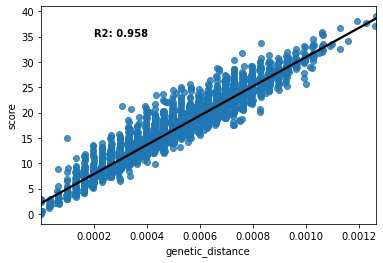

In [53]:
data = distance_comparison
p1 = sns.regplot(y='score', x='genetic_distance', 
            data=data, line_kws={'color': 'black'})
# add text annotation
p1.text(0.0002, 35, f'R2: {r_value:.3f}', horizontalalignment='left', 
        size='medium', color='black', weight='semibold')

plt.savefig('freq_v_genetic.png')
plt.show()

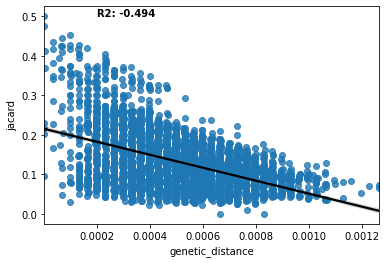

In [57]:
slope, intercept, r_value, pv, se = stats.linregress(data['genetic_distance'],data['jacard'])
data = distance_comparison
p1 = sns.regplot(y='jacard', x='genetic_distance', 
            data=data, line_kws={'color': 'black'})
# add text annotation
p1.text(0.0002, 0.5, f'R2: {r_value:.3f}', horizontalalignment='left', 
        size='medium', color='black', weight='semibold')
plt.savefig('jacard_v_genetic.png')
plt.show()

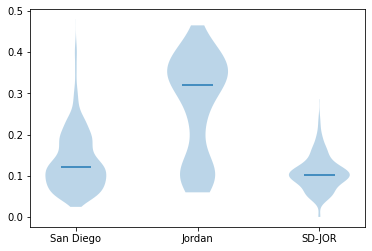

In [60]:
sd_scores = distance_comparison[(distance_comparison.location_x.str.contains('San Diego')) 
                    & (distance_comparison.location_y.str.contains('San Diego'))]['jacard']
jor_scores = distance_comparison[(distance_comparison.location_x.str.contains('Jordan')) 
                    & (distance_comparison.location_y.str.contains('Jordan'))]['jacard']
sd_jor_scores = distance_comparison[(distance_comparison.location_x.str.contains('San Diego')) 
                    & (distance_comparison.location_y.str.contains('Jordan'))]['jacard']

f, ax = plt.subplots()
data = [sd_scores, jor_scores, sd_jor_scores]
ax.violinplot(data, showmedians=True, showextrema=False)
ax.set_xticks([1,2,3])
ax.set_xticklabels(["San Diego", "Jordan", "SD-JOR"])
plt.savefig('jacard_dist_per_location.png')
plt.show()

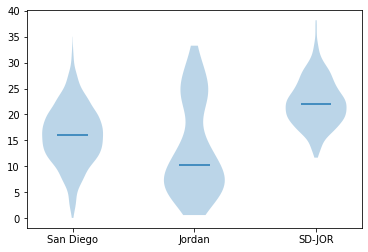

In [58]:
sd_scores = distance_comparison[(distance_comparison.location_x.str.contains('San Diego')) 
                    & (distance_comparison.location_y.str.contains('San Diego'))]['score']
jor_scores = distance_comparison[(distance_comparison.location_x.str.contains('Jordan')) 
                    & (distance_comparison.location_y.str.contains('Jordan'))]['score']
sd_jor_scores = distance_comparison[(distance_comparison.location_x.str.contains('San Diego')) 
                    & (distance_comparison.location_y.str.contains('Jordan'))]['score']

f, ax = plt.subplots(ncols=2)
data = [sd_scores, jor_scores, sd_jor_scores]
ax.violinplot(data, showmedians=True, showextrema=False)
ax.set_xticks([1,2,3])
ax.set_xticklabels(["San Diego", "Jordan", "SD-JOR"])
plt.savefig('freq_dist_per_location.png')
plt.show()

In [55]:
distance_comparison.location_x.unique()
distance_comparison.columns

Index(['sample_idx_x', 'sample_idx_y', 'jacard', 'score', 'location_x',
       'location_y', 'collection_date_x', 'collection_date_y',
       'genetic_distance'],
      dtype='object')

In [56]:
sd_scores = distance_comparison[(distance_comparison.location_x.str.contains('San Diego')) 
                    & (distance_comparison.location_y.str.contains('San Diego'))]['genetic_distance']
jor_scores = distance_comparison[(distance_comparison.location_x.str.contains('Jordan')) 
                    & (distance_comparison.location_y.str.contains('Jordan'))]['genetic_distance']
sd_jor_scores = distance_comparison[(distance_comparison.location_x.str.contains('San Diego')) 
                    & (distance_comparison.location_y.str.contains('Jordan'))]['genetic_distance']

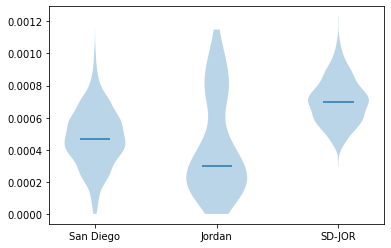

In [57]:
f, ax = plt.subplots()
data = [sd_scores, jor_scores, sd_jor_scores]
ax.violinplot(data, showmedians=True, showextrema=False)
ax.set_xticks([1,2,3])
ax.set_xticklabels(["San Diego", "Jordan", "SD-JOR"])
plt.savefig('tree_dist_per_location.png')
plt.show()

$$ A = \sum \limits_{i \in \{A \cup B \}} |f^{A}_{i} - f^{B}_{i}|$$

In [51]:
pairwise_similarity.columns

Index(['sample_idx_x', 'sample_idx_y', 'jacard', 'score', 'location_x',
       'location_y', 'collection_date_x', 'collection_date_y'],
      dtype='object')

In [46]:
genetic_distances = {}
for t in tree.get_terminals():
    q = t.name.split('-')
    if len(q)==3:
        s = int(q[1])
        genetic_distances[sam2idx[s]] = tree.distance(t)
# genetic_distances

In [110]:
def compute_reference_similarity(x):
    variants = isnv_book[x].keys()
    d = 0
    for var in variants:
        d += abs(isnv_book[x][var])
    num_vars = len(isnv_book[x].keys())
    return d

In [111]:
abs_distances = pd.DataFrame()
abs_distances['sample_idx'] = genetic_distances.keys()
abs_distances['genetic_distance'] = abs_distances['sample_idx'].apply(lambda x: genetic_distances[x])
abs_distances['isnv_distance'] = abs_distances['sample_idx'].apply(compute_reference_similarity)
abs_distances.sort_values('genetic_distance', ascending=False)

,sample_idx,genetic_distance,isnv_distance
808,1677,0.000834,25.821744
806,2517,0.000831,25.122967
807,2451,0.000831,24.985206
954,78,0.000830,25.368661
955,19,0.000830,25.412746
...,...,...,...
704,2089,0.000200,6.515257
622,1797,0.000200,6.214376
598,1724,0.000200,6.368247
590,491,0.000200,7.556317


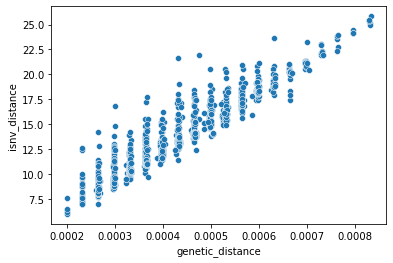

In [112]:
sns.scatterplot(y='isnv_distance', x='genetic_distance', data=abs_distances)
plt.show()

In [113]:
pairwise_similarity.location_x.value_counts()

USA/California/San Diego            4951743
Jordan/Amman                         515967
MEX/Baja California/Tijuana          390184
USA/California/Imperial              320875
USA/Louisiana/New Orleans            269535
USA/California/Cruise_Ship_2          82144
USA/California/Cruise_Ship_1          20536
Jordan/Irbid                          10268
Jordan/Mafraq                          5134
USA/California/Riverside               5134
MEX/Sonora/San Luis Río Colorado       5134
USA/California/Los Angeles             5134
USA/California/San Bernadino           2567
MEX/Baja California/Mexicali           2567
USA/California/Santa Barbara           2567
USA/Arizona/Yuma                       2567
Name: location_x, dtype: int64

In [114]:
locwise_similarity = pairwise_similarity.loc[(pairwise_similarity['location_x']==pairwise_similarity['location_y'])]
locwise_similarity.location_x.value_counts()

USA/California/San Diego            3719112
Jordan/Amman                          40200
MEX/Baja California/Tijuana           22952
USA/California/Imperial               15500
USA/Louisiana/New Orleans             10920
USA/California/Cruise_Ship_2            992
USA/California/Cruise_Ship_1             56
Jordan/Irbid                             12
Jordan/Mafraq                             2
USA/California/Riverside                  2
MEX/Sonora/San Luis Río Colorado          2
USA/California/Los Angeles                2
Name: location_x, dtype: int64

In [115]:
data = locwise_similarity.groupby('location_x').sample(1000, replace=True)

In [116]:
def compute_time_delta(x):
    d1 = x['collection_date_x'].split('-')
    d2 = x['collection_date_y'].split('-')
    ans = np.nan
    if len(d1) == 3 and len(d2) == 3:
        yrs = abs(int(d1[0]) - int(d2[0]))*365
        mnths = abs(int(d1[1]) - int(d2[1]))*30
        days = abs(int(d1[2]) - int(d2[2]))
        ans = yrs+mnths+days
    return ans
locwise_similarity['time_delta_days'] = locwise_similarity.apply(compute_time_delta, axis=1)

/Users/al/anaconda3/envs/scripps/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [117]:
print(locwise_similarity.shape)
locwise_similarity = locwise_similarity[~locwise_similarity['time_delta_days'].isna()]
locwise_similarity.shape

(3809752, 9)


(3805896, 9)

In [118]:
pairwise_similarity['same_location'] = False
pairwise_similarity.loc[(pairwise_similarity['location_x']==pairwise_similarity['location_y']), 'same_location'] = True

/Users/al/anaconda3/envs/scripps/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/al/anaconda3/envs/scripps/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [91]:
# us_jor

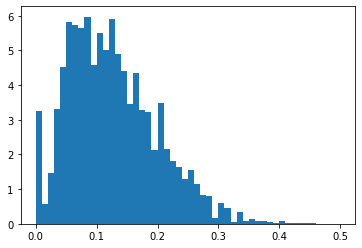

In [166]:
sd_scores = locwise_similarity[locwise_similarity['location_x'].str.contains('San Diego')]['jacard']
plt.hist(sd_scores, density=True, bins=50)
plt.savefig('sd_jacard_hist.png')
plt.show()

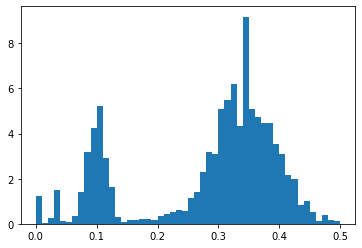

In [167]:
jor_scores = locwise_similarity[locwise_similarity['location_x'].str.contains('Jordan')]['jacard']
plt.hist(jor_scores, density=True, bins=50)
plt.savefig('jor_jacard_hist.png')
plt.show()

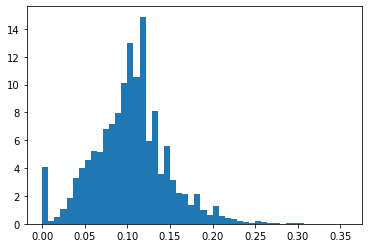

In [168]:
plt.hist(sd_jor_scores, density=True, bins=50)
plt.savefig('sd_jor_jacard_hist.png')
plt.show()

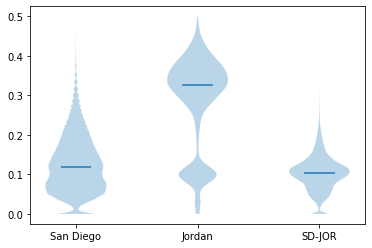

In [169]:
f, ax = plt.subplots()
data = [sd_scores, jor_scores, sd_jor_scores]
ax.violinplot(data, showmedians=True, showextrema=False)
ax.set_xticks([1,2,3])
ax.set_xticklabels(["San Diego", "Jordan", "SD-JOR"])
plt.savefig('jacard_dist_per_location.png')
plt.show()

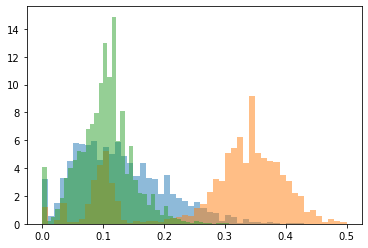

In [122]:
sd_jor_scores = pairwise_similarity[(pairwise_similarity.location_x.str.contains('San Diego')) 
                    & (pairwise_similarity.location_y.str.contains('Jordan'))]['jacard']
plt.hist(sd_scores, density=True, bins=50, alpha=0.5,)
plt.hist(jor_scores, density=True, bins=50, alpha=0.5)
plt.hist(sd_jor_scores, density=True, bins=50, alpha=0.5)
plt.show()

In [93]:
# sns.histplot(locwise_similarity, x='score', hue='location_x')

In [105]:
pairwise_similarity

,sample_idx_x,sample_idx_y,jacard,score,location_x,location_y,collection_date_x,collection_date_y
0,1197,1207,0.000000,14.015675,Jordan/Amman,Jordan/Amman,2020-04-06,2020-04-06
1,1210,1207,0.075000,3.934157,Jordan/Amman,Jordan/Amman,2020-04-07,2020-04-06
2,1199,1207,0.009479,23.925118,Jordan/Amman,Jordan/Amman,2020-04-08,2020-04-06
3,1768,1207,0.010870,18.516578,Jordan/Amman,Jordan/Amman,2020-06-21,2020-04-06
4,1743,1207,0.000000,21.755866,Jordan/Amman,Jordan/Amman,2020-07-04,2020-04-06
...,...,...,...,...,...,...,...,...
6592051,266,1197,0.000000,21.582150,USA/Louisiana/New Orleans,Jordan/Amman,2020-05-14,2020-04-06
6592052,283,1197,0.000000,25.334121,USA/Louisiana/New Orleans,Jordan/Amman,2020-05-14,2020-04-06
6592053,306,1197,0.000000,18.368329,USA/Louisiana/New Orleans,Jordan/Amman,2020-05-14,2020-04-06
6592054,318,1197,0.000000,16.701525,USA/Louisiana/New Orleans,Jordan/Amman,2020-05-14,2020-04-06


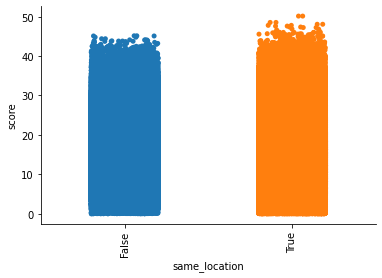

In [94]:
# import seaborn as sns
g = sns.stripplot(x='same_location', y='score', data=pairwise_similarity, jitter=0.2)
sns.despine()
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [95]:
us_jor = pairwise_similarity.loc[((pairwise_similarity.location_x.str.contains('USA')) | (pairwise_similarity.location_x.str.contains('Jordan')))
                                 & ((pairwise_similarity.location_y.str.contains('USA')) | (pairwise_similarity.location_y.str.contains('Jordan')))]
us_jor

,sample_idx_x,sample_idx_y,score,location_x,location_y,collection_date_x,collection_date_y,same_location
0,1197,1207,14.015675,Jordan/Amman,Jordan/Amman,2020-04-06,2020-04-06,True
1,1210,1207,3.934157,Jordan/Amman,Jordan/Amman,2020-04-07,2020-04-06,True
2,1199,1207,23.925118,Jordan/Amman,Jordan/Amman,2020-04-08,2020-04-06,True
3,1768,1207,18.516578,Jordan/Amman,Jordan/Amman,2020-06-21,2020-04-06,True
4,1743,1207,21.755866,Jordan/Amman,Jordan/Amman,2020-07-04,2020-04-06,True
...,...,...,...,...,...,...,...,...
6592051,266,1197,21.582150,USA/Louisiana/New Orleans,Jordan/Amman,2020-05-14,2020-04-06,False
6592052,283,1197,25.334121,USA/Louisiana/New Orleans,Jordan/Amman,2020-05-14,2020-04-06,False
6592053,306,1197,18.368329,USA/Louisiana/New Orleans,Jordan/Amman,2020-05-14,2020-04-06,False
6592054,318,1197,16.701525,USA/Louisiana/New Orleans,Jordan/Amman,2020-05-14,2020-04-06,False


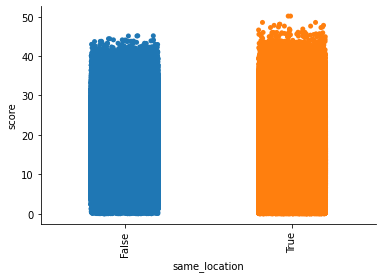

In [96]:
g = sns.stripplot(x='same_location', y='score', data=us_jor, jitter=0.2)
sns.despine()
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

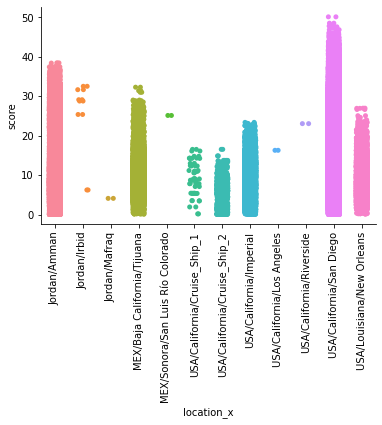

In [97]:
g = sns.stripplot(x='location_x', y='score', data=locwise_similarity, jitter=0.2)
sns.despine()
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [79]:
isnvs[isnvs['sample_idx']==1751]

,location,collection_date,sample_idx,var_idx,freq
260,Jordan/Amman,2020-07-04,1751,0,1.000000
261,Jordan/Amman,2020-07-04,1751,3,1.000000
262,Jordan/Amman,2020-07-04,1751,9,0.999254
263,Jordan/Amman,2020-07-04,1751,15,0.999638
264,Jordan/Amman,2020-07-04,1751,213,0.999673
265,Jordan/Amman,2020-07-04,1751,216,0.999546
266,Jordan/Amman,2020-07-04,1751,217,1.000000
267,Jordan/Amman,2020-07-04,1751,761,0.999317
268,Jordan/Amman,2020-07-04,1751,1025,0.999177
269,Jordan/Amman,2020-07-04,1751,1457,0.999596


In [80]:
isnvs[isnvs['sample_idx']==1210]

,location,collection_date,sample_idx,var_idx,freq
79,Jordan/Amman,2020-04-07,1210,4,0.035743
80,Jordan/Amman,2020-04-07,1210,5,0.109584
81,Jordan/Amman,2020-04-07,1210,6,0.999800
82,Jordan/Amman,2020-04-07,1210,837,0.996967
83,Jordan/Amman,2020-04-07,1210,842,0.999813
84,Jordan/Amman,2020-04-07,1210,3194,0.999111
85,Jordan/Amman,2020-04-07,1210,14611,0.036464
86,Jordan/Amman,2020-04-07,1210,14612,0.060601


### TODO:
* initialize `n x n-1` matrix where `n` is number of distinct samples
* get variants 2 index mapping
* get index 2 variant mapping 
* each sample has one-hot encoded alt_freq vector with shape `m` where `m` is number of distinct variants
* for each sample compute pair_wise distance with all other samples (see whiteboard for formula)
$$d_{ij} = (x_{i} - x_{j}).abs().sum()$$

## Input Parameters

In [27]:
# these are the columns to include in the metadata.csv output
meta_columns = ['sample_id', 'Virus name', 'Submitting lab', 'Location', 'Collection date', 'AVG_DEPTH', 'COVERAGE']

In [28]:
# path to reference sequence (used later for MSA and tree construction)
ref_path = Path('/home/gk/code/hCoV19/db/NC045512.fasta')

In [29]:
# this is the directory where results get saved
out_dir = Path('/home/al/data/covid_release_test')
# number of cores to use 
num_cpus = 8

In [30]:
# file path to samples sheet (make sure it is the most recent)
sample_sheet_fpath = '/home/al/code/covid/sequence_release/COVID_sequencing_summary - GISAID.csv'
# path to analysis results
analysis_fpath = '/home/gk/analysis/'
# file path to metadata of samples that have already been released
released_samples_fpath = '/home/al/code/covid/HCoV-19-Genomics/metadata.csv'

## Collecting Sequence Data

In [31]:
def get_ids(filepaths: list) -> list:
    "Utility function to get a unified sample ID format from the analysis file paths"
    ids = []
    for fp in filepaths:
        query = fp.basename().split('-')
        if len(query) > 1:
            ids.append(''.join(query[:2]))
        else:
            start_idx = fp.find('SEARCH')
            ids.append(fp[start_idx:start_idx+10])
    return ids

In [32]:
# grab all filepaths for bam data
bam_filepaths = !find {analysis_fpath} -type f -path '*merged_aligned_bams/illumina*' -name '*.bam'
bam_filepaths = [Path(fp) for fp in bam_filepaths]

In [33]:
# consolidate sample ID format
bam_ids = get_ids(bam_filepaths)

In [34]:
len(bam_filepaths), len(bam_ids)

(393, 393)

In [35]:
# Turn into dataframe
bam_data = list(zip(*[bam_ids, bam_filepaths]))

bam_df = pd.DataFrame(data=bam_data, columns=['sample_id', 'PATH'])

In [36]:
# grab all paths to consensus sequences
consensus_filepaths = !find {analysis_fpath} -type f -path '*consensus_sequences/illumina*' -name '*.fa'
consensus_filepaths = [Path(fp) for fp in consensus_filepaths]

In [37]:
# consolidate sample ID format
consensus_ids = get_ids(consensus_filepaths)

In [38]:
len(consensus_filepaths), len(consensus_ids)

(4404, 4404)

In [39]:
# Turn into dataframe
consensus_data = list(zip(*[consensus_ids, consensus_filepaths]))

consensus_df = pd.DataFrame(data=consensus_data, columns=['sample_id', 'PATH'])

In [40]:
# con

In [41]:
# clean up
bam_df.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
bam_df.shape

(388, 2)

In [42]:
# clean up
consensus_df.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
consensus_df.shape

(4356, 2)

In [43]:
# include only SEARCH samples
consensus_df = consensus_df[(consensus_df['sample_id'].str.contains('SEARCH'))]

In [44]:
# merge consensus and bam filepaths for each sample ID
analysis_df = pd.merge(consensus_df, bam_df, on='sample_id', how='left')
# exclude any samples that do not have BAM data
num_samples_missing_bams = analysis_df[analysis_df['PATH_y'].isna()].shape
# analysis_df = analysis_df[~analysis_df['PATH_y'].isna()]

In [45]:
# load sample sheet data (GISAID) - make sure to download most recent one 
seqsum = pd.read_csv(sample_sheet_fpath)

In [46]:
consensus_df

,sample_id,PATH
0,SEARCH3914,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
1,SEARCH3987,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
2,SEARCH3962,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
3,SEARCH4063,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
4,SEARCH4050,/home/gk/analysis/2020.10.27.hCoV19/consensus_...
...,...,...
4399,SEARCH0171,/home/gk/analysis/2020.05.01.hCoV19/consensus_...
4400,SEARCH0147,/home/gk/analysis/2020.05.01.hCoV19/consensus_...
4401,SEARCH0166,/home/gk/analysis/2020.05.01.hCoV19/consensus_...
4402,SEARCH0161,/home/gk/analysis/2020.05.01.hCoV19/consensus_...


In [47]:
num_samples_missing_bams

(4328, 3)

In [48]:
# clean up
seqsum = seqsum[(~seqsum['SEARCH SampleID'].isna()) & (seqsum['SEARCH SampleID']!='#REF!')]

In [49]:
seqsum.shape

(4111, 34)

In [50]:
def process_id(x):
    "Utility function to process sample IDs to fix inconsistencies in the format"
    return ''.join(x.split('-')[:2])
# consolidate sample ID format
seqsum.loc[:, 'sample_id'] = seqsum['SEARCH SampleID'].apply(process_id)
# seqsum['sample_id']

In [51]:
seqsum.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
seqsum.shape

(4070, 35)

In [52]:
print(seqsum.shape)
seqsum = seqsum[seqsum['New sequences ready for release'] == 'Yes']
print(seqsum.shape)

(4070, 35)
(1205, 35)


In [53]:
sequence_results = pd.merge(seqsum, consensus_df, on='sample_id', how='inner')

print(sequence_results.shape)

(1205, 36)


In [5]:
# sequence_results

In [57]:
# num_samples_missing_bams = sequence_results[sequence_results['PATH_y'].isna()].shape[0]
num_samples_missing_cons = sequence_results[sequence_results['PATH'].isna()].shape[0]

print(num_samples_missing_bams)
print(num_samples_missing_cons)

(4328, 3)
0


## Make sure to remove any samples that have already been uploaded to github (just an extra safety step)

In [58]:
# load metadata.csv from github repo, then clean up
meta_df = pd.read_csv(released_samples_fpath)
print(meta_df.shape)
meta_df = meta_df[meta_df['ID'].str.contains('SEARCH')]
print(meta_df.shape)

(1195, 9)
(1193, 9)


In [59]:
# consolidate sample ID format
meta_df.loc[:, 'sample_id'] = meta_df['ID'].apply(process_id)
# meta_df['sample_id']

In [60]:
# get IDs of samples that have already been released
released_seqs = meta_df['sample_id'].unique()

In [61]:
# filter out released samples from all the samples we got
final_result = sequence_results#[~sequence_results['sample_id'].isin(released_seqs)]
print(final_result.shape)

(1205, 36)


In [69]:
final_result['loc'] = final_result['Location'].apply(lambda x: x.split('/')[0])
jor_cns_filepaths = final_result.loc[(final_result['loc']=='JOR') & (final_result['Ready for release?']=='Yes')]

In [71]:
def transfer_files(filepaths: pd.DataFrame, destination: str, include_bams=False):
    "Utility function to copy consensus and BAM files of given samples dataframe"
    filepaths = filepaths['PATH']
    destination = Path(destination)
    if not Path.isdir(destination):
        Path.mkdir(destination);
        Path.mkdir(destination/'fa/')
        Path.mkdir(destination/'bam/')
    for fp in filepaths.values:
        cons_fp = fp
        copy(cons_fp, destination/'fa/')
        if include_bams:
            copy(bam_fp, destination/'bam/')
    return 0
transfer_files(jor_cns_filepaths, '/home/al/data/jordan')

0

In [72]:
out_dir = '/home/al/data/jordan'

In [43]:
def compress_files(filepaths: list, destination='/home/al/tmp2/fa/samples.tar.gz'):
    "Utility function to compress list of files into a single .tar.gz file"
    with tarfile.open(destination, "w:gz") as tar:
        for f in filepaths:
            tar.add(f)
    return 0

In [44]:
# t = Path('/home/al/tmp2/fa/').listdir()
# compress_files(t)

## Getting coverage information

In [77]:
cov_filepaths = !find {analysis_fpath} -type f -path '*trimmed_bams/illumina/reports*' -name '*.tsv'
cov_filepaths = [Path(fp) for fp in cov_filepaths]

In [78]:
cov_df = pd.concat((pd.read_csv(f, sep='\t').assign(path=f) for f in cov_filepaths))

In [79]:
cov_df.head()

,SAMPLE,COVERAGE,AVG_DEPTH,MIN,MAX,ZERO_DEPTH,path
0,SEARCH-3924-JOR_L001_L002_L003_L004.trimmed.so...,0.0000,0.10592,0,3,26828,/home/gk/analysis/2020.10.27.hCoV19/trimmed_ba...
1,SEARCH-4030-JOR_L001_L002_L003_L004.trimmed.so...,98.0618,3657.67000,0,8007,52,/home/gk/analysis/2020.10.27.hCoV19/trimmed_ba...
2,SEARCH-4029-JOR_L001_L002_L003_L004.trimmed.so...,98.7113,4270.41000,1,8009,0,/home/gk/analysis/2020.10.27.hCoV19/trimmed_ba...
3,SEARCH-3998-JOR_L001_L002_L003_L004.trimmed.so...,99.0445,4397.36000,1,8005,0,/home/gk/analysis/2020.10.27.hCoV19/trimmed_ba...
4,SEARCH-4066-JOR_L001_L002_L003_L004.trimmed.so...,99.3777,751.40400,5,5517,0,/home/gk/analysis/2020.10.27.hCoV19/trimmed_ba...


In [80]:
def process_coverage_sample_ids(x):
    "Utility function to get a unified sample ID format from the coverage reports"
    query = x.split('/')
    if len(query) == 1:
        return ''.join(x.split('-')[:2])
    else:
        start_idx = x.find('SEARCH')
        return x[start_idx:start_idx+10]
        
cov_df['sample_id'] = cov_df['SAMPLE'].apply(process_coverage_sample_ids)
cov_df['date'] = cov_df['path'].apply(lambda x: ''.join(x.split('/')[4].split('.')[:3]))

In [49]:
cov_df = (cov_df.sort_values('date')
          .drop_duplicates(subset=['sample_id'], keep='last'))
cov_df.shape

(3955, 9)

In [50]:
ans = pd.merge(final_result, cov_df, on='sample_id')[meta_columns]
ans.head()

,sample_id,Virus name,Submitting lab,Location,Collection date,AVG_DEPTH,COVERAGE
0,SEARCH1996,hCoV-19/USA/SEARCH-1996-SAN/2020,Andersen lab at Scripps Research,USA/California/San Diego,2020-05-14,3034.85,100.0
1,SEARCH2004,hCoV-19/USA/SEARCH-2004-SAN/2020,Andersen lab at Scripps Research,USA/California/San Diego,2020-05-08,8832.41,100.0
2,SEARCH2005,hCoV-19/USA/SEARCH-2005-SAN/2020,Andersen lab at Scripps Research,USA/California/San Diego,2020-05-12,2054.16,100.0
3,SEARCH2010,hCoV-19/USA/SEARCH-2010-SAN/2020,Andersen lab at Scripps Research,USA/California/San Diego,2020-05-14,2441.08,100.0
4,SEARCH2011,hCoV-19/USA/SEARCH-2011-SAN/2020,Andersen lab at Scripps Research,USA/California/San Diego,2020-05-14,5040.19,100.0


In [51]:
ans.to_csv(out_dir/'metadata.csv', index=False)

## Data Logging

In [53]:
low_coverage_samples = ans[ans['COVERAGE'] < 90]

In [74]:
with open(f'{out_dir}/data_release.log', 'w') as f:
    f.write(f'{low_coverage_samples.shape[0]} samples were found to have coverage below 90%\n')
    f.write(f'{num_samples_missing_cons} samples were ignored because they were missing consensus sequence files\n')
    f.write(f'{num_samples_missing_bams} samples were ignored because they were missing BAM sequence files\n')

## Renaming Samples

In [74]:
out_dir = Path(out_dir)

In [75]:
cons_seqs = Path(out_dir/'fa')

In [82]:
sampleid2name = pd.Series(jor_cns_filepaths['Virus name'].values,index=jor_cns_filepaths['sample_id']).to_dict()

In [6]:
# sampleid2name.get(sample_id, 'NA')
# sampleid2name

In [85]:
renamed_dir = out_dir/'fa_renamed'
def rename_fasta_headers(renamed_dir: str=renamed_dir):
    """A Utility function to rename the headers of each consensus sequence"""
    if not Path.isdir(renamed_dir):
        Path.mkdir(renamed_dir);
    for seq_path in cons_seqs.listdir():
        with open(seq_path, 'r') as f:
            records = SeqIO.parse(f, 'fasta')
            for record in records:
                sample_id = ''.join(record.id.split('_')[1].split('-')[:2])
                sample_name = sampleid2name.get(sample_id, 'NA').split('/')[2]
                record.id = sample_name
                record.description = sample_name
                SeqIO.write(record, renamed_dir/seq_path.basename(), 'fasta')
    return 0
rename_fasta_headers(renamed_dir)

0

## Multiple Sequence Alignment

In [86]:
cons_seqs = Path(out_dir/'fa_renamed')

In [87]:
copy(ref_path, cons_seqs)

Path('/home/al/data/jordan/fa_renamed/NC045512.fasta')

In [88]:
msa_dir = out_dir/'msa'
if not Path.isdir(msa_dir):
    Path.mkdir(msa_dir);

In [90]:
num_cpus = 20

In [91]:
!cat {cons_seqs}/*.fa* > all_seqs_merged.fa
!mafft --auto --thread {num_cpus} all_seqs_merged.fa > {msa_dir}/msa.fa
!rm all_seqs_merged.fa

nthread = 20
nthreadpair = 20
nthreadtb = 16
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 11483 ambiguous characters.
  201 / 204 (thread   14)
done.

Constructing a UPGMA tree (efffree=0) ... 
  200 / 204
done.

Progressive alignment 1/2... 
STEP   203 / 203 (thread    0)
done.

Making a distance matrix from msa.. 
  200 / 204 (thread   10)
done.

Constructing a UPGMA tree (efffree=1) ... 
  200 / 204
done.

Progressive alignment 2/2... 
STEP   203 / 203 (thread   15)
done.

disttbfast (nuc) Version 7.464
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
16 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has bee

In [92]:
!ls {out_dir}

bam  fa  fa_renamed  msa


## Tree Construction

In [ ]:
!iqtree -s {msa_dir}/msa.fa -T {num_cpus} -m TEST -czb

## Tree Visualization - Baseline

In [36]:
patient_zero = 'NC_045512.2'

In [37]:
msa_dir = Path('/Users/al/Documents/scripps/data/jor_del/msa/')

In [38]:
tree_path = f"{msa_dir/'msa.fa'}.treefile"
tree = next(Phylo.parse(tree_path, 'newick'))
print(tree.rooted)
# root with genome from patient zero
tree.root_with_outgroup(patient_zero)
print(tree.rooted)

False
True


In [39]:
def get_coords(tree):
    for _i, i in enumerate(tree.get_terminals()):
        i.y = _i
        i.x = tree.distance(i)

    for i in reversed(tree.get_nonterminals()):
        _ = i.clades
        i.y = (_[0].y + _[-1].y)/2
        i.x = tree.distance(i)
    return tree
tree = get_coords(tree)

In [64]:
plt.rcParams["figure.figsize"] = (20,60)

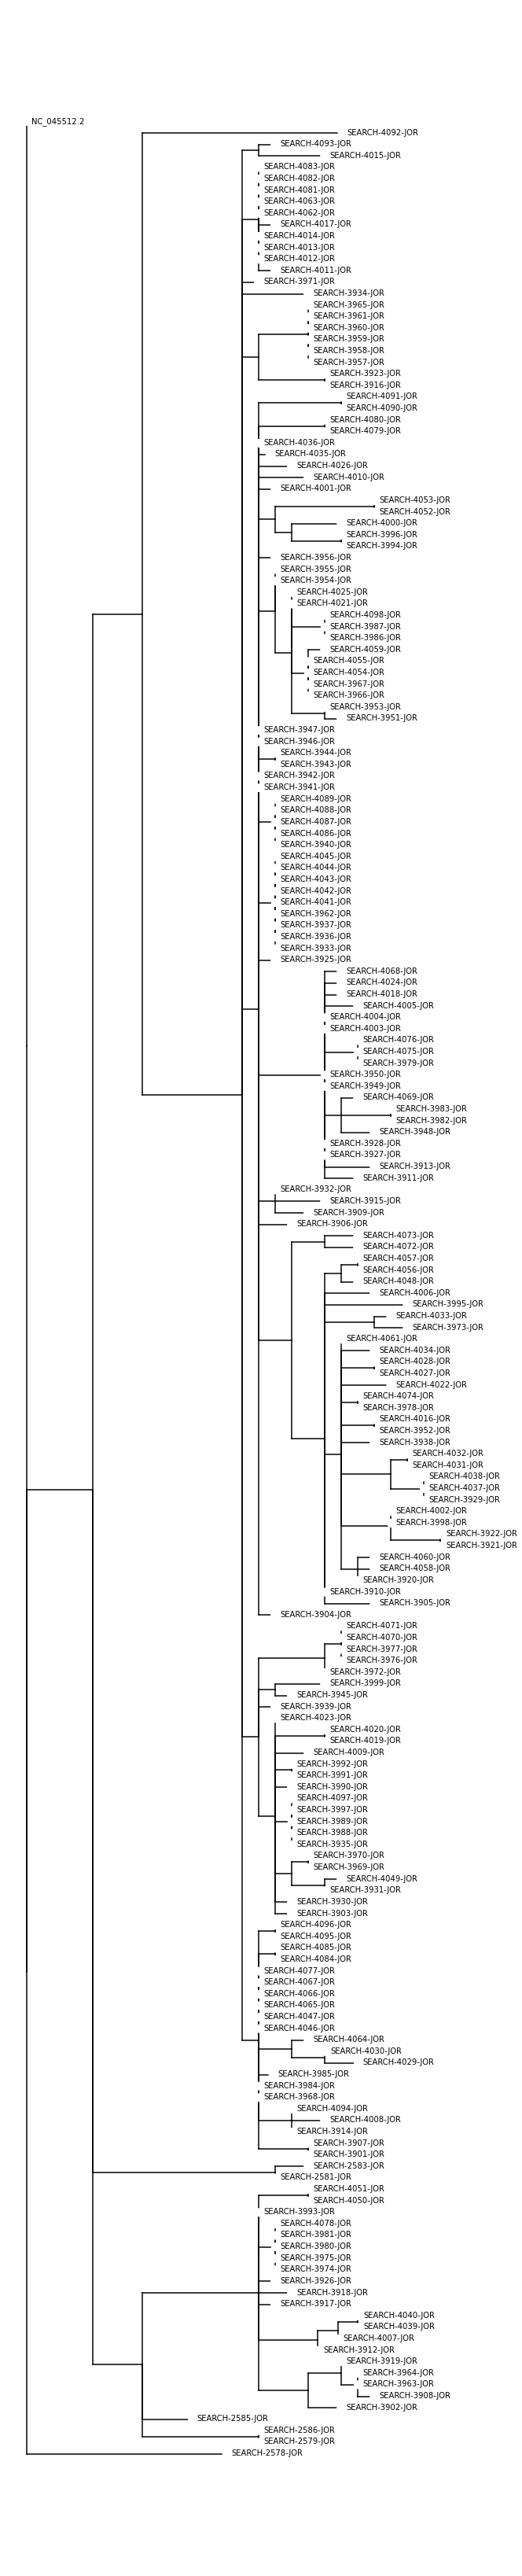

In [44]:
f = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.75], height_ratios = [0.5,0.5])

ax = plt.subplot(gs[:,0])
for i in tree.get_nonterminals():
    for j in i.clades:
#         if prune_clade(j, deletion_samples): continue
        _t = ax.plot([i.x, i.x], [i.y, j.y], ls='-', color="#000000", zorder = 1)
        _t = ax.plot([i.x, j.x], [j.y, j.y], ls='-', color="#000000", zorder = 1)
        
_ = {
    "x": [],
    "y": [],
    "c": []
}
for i in tree.get_terminals():
    _["x"].append(i.x)
    _["y"].append(i.y)
    _["c"].append('white')
    
    ax.text(i.x+1e-5, i.y-1e-1, i.name)
#     _["c"].append(c)
    # ax.text(i.x+0.001, i.y, i.name.split("_")[3])
    # if i.name in hp["taxon name"].tolist():
    #     ax.text(i.x + 0.000025, i.y, i.name.split("_")[0] + " " + str(hp[hp["taxon name"] == i.name]["#of homoplasic mutations"].values[0]))
# ax.text(_["x"], _["y"], _["text"])
ax.scatter(_["x"], _["y"], c=_['c'], s = 100, zorder = 2)
ax.scatter(_["x"], _["y"], c=_['c'], s = 50, zorder = 2)
# ax.legend(handles=legend)
f.patch.set_visible(False)
ax.axis('off')
plt.show()

## Tree Visualization: Consensus Deletions

In [69]:
from path import Path

In [70]:
out_dir = Path('/Users/al/Documents/scripps/data/jor_del/')

In [71]:
fp = out_dir/'msa/msa.fa'
jor_dels = identify_deletions(fp, patient_zero)
jor_dels['del_coords'] = jor_dels['del_coords'].apply(adjust_coords)
jor_dels.to_csv(out_dir/'viz/deletions.csv', index=False)
jor_dels = pd.read_csv(out_dir/'viz/deletions.csv')
jor_dels['samples'] = jor_dels['samples'].apply(lambda x: x[1:-1].split())
jor_dels

,del_coords,del_len,samples,num_samples
0,27696:27749,54,['SEARCH-4026-JOR'],1
1,27793:27796,4,['SEARCH-3934-JOR'],1
2,28239:28242,4,"['SEARCH-4018-JOR', 'SEARCH-4019-JOR']",2
3,685:693,9,"['SEARCH-3969-JOR', 'SEARCH-3970-JOR']",2
4,28089:28091,3,"['SEARCH-3903-JOR', 'SEARCH-3906-JOR', 'SEARCH...",27


In [72]:
import matplotlib
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

# TODO: specify `colors` dynamically based on number of distinct deletions
def get_del2color(deletions: pd.DataFrame, colors: list) -> dict:
    del2color = {}
    for i, td in enumerate(deletions.iterrows()):
        deletion = td[1]['del_coords']
        del2color[deletion] = colors[i]
    return del2color
colors = list(mcolors.TABLEAU_COLORS.keys())
del2color = get_del2color(jor_dels, colors)
print(del2color)

{'27696:27749': 'tab:blue', '27793:27796': 'tab:orange', '28239:28242': 'tab:green', '685:693': 'tab:red', '28089:28091': 'tab:purple'}


In [93]:
def get_sample2color(deletions: pd.DataFrame, colors: list) -> dict:
    deletions.sort_values('num_samples', inplace=True)
    sample_colors = {}
    del2color = get_del2color(deletions, colors)
    for i, td in enumerate(deletions.iterrows()):
        deletion = td[1]['del_coords']
        samples = td[1]['samples']
        for sample in samples:
#             print(sample)
            sample_colors[eval(sample)] = {'color': del2color[deletion],
                                           'freq': 1.}
    return sample_colors
sample_colors = get_sample2color(jor_dels, colors)
len(sample_colors)

33

In [74]:
# sample_colors

In [75]:
def generate_color_array(colors, opacities):
    co = np.zeros((len(colors), 4))
    for i, (c, o) in enumerate(zip(colors, opacities)):

        co[i, :3] = matplotlib.colors.to_rgb(c)
        co[i, 3] = o
    return co

In [120]:
def get_del_legend(del2color: dict) -> list:
    legend_elements = [Line2D([0], [0], marker='o', color=x, label=y,
                       markerfacecolor=x, markersize=15) for y, x in del2color.items()]
    return legend_elements
legend = get_del_legend(del2color)
legend

In [121]:
plt.rcParams["figure.figsize"] = (40,100)

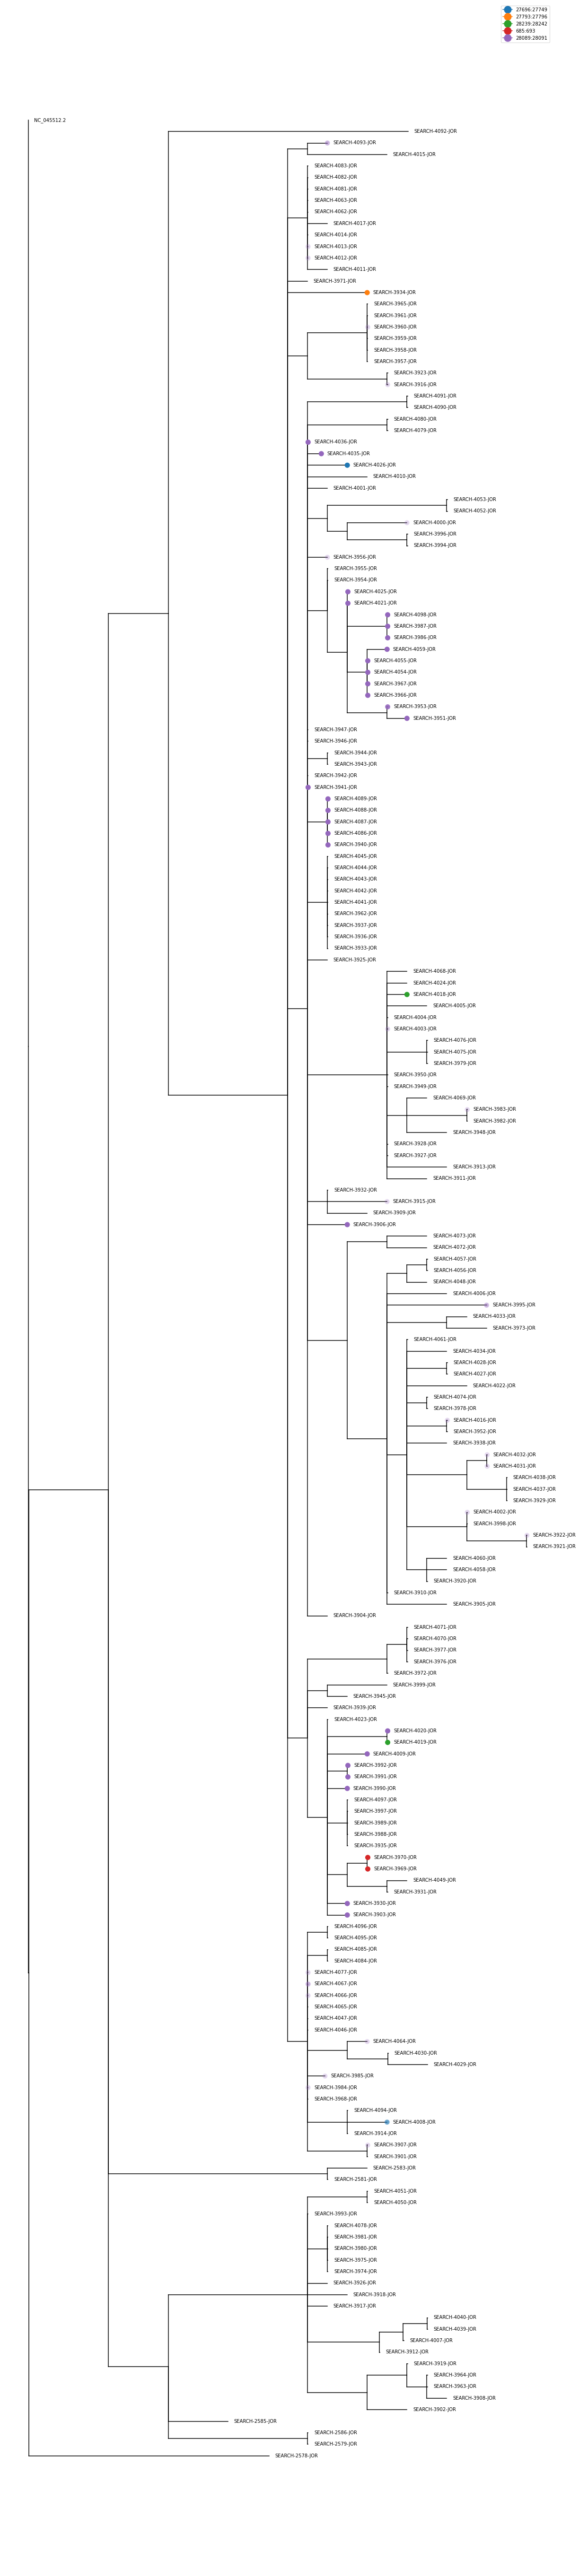

In [122]:
f = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.75], height_ratios = [0.5,0.5])

ax = plt.subplot(gs[:,0])
for i in tree.get_nonterminals():
    for j in i.clades:
#         if prune_clade(j, deletion_samples): continue
        _t = ax.plot([i.x, i.x], [i.y, j.y], ls='-', color="#000000", zorder = 1)
        _t = ax.plot([i.x, j.x], [j.y, j.y], ls='-', color="#000000", zorder = 1)
        
_ = {
    "x": [],
    "y": [],
    "c": [],
    "o": [],
}
for i in tree.get_terminals():
    _["x"].append(i.x)
    _["y"].append(i.y)
    _["c"].append(sample_colors.get(i.name, {'color': 'white'})['color'])
    _["o"].append(sample_colors.get(i.name, {'freq': 0.})['freq'])
    ax.text(i.x+1e-5, i.y-1e-1, i.name)
#     _["c"].append(c)
    # ax.text(i.x+0.001, i.y, i.name.split("_")[3])
    # if i.name in hp["taxon name"].tolist():
    #     ax.text(i.x + 0.000025, i.y, i.name.split("_")[0] + " " + str(hp[hp["taxon name"] == i.name]["#of homoplasic mutations"].values[0]))
# ax.text(_["x"], _["y"], _["text"])
_["co"] = generate_color_array(_["c"], _["o"])
ax.scatter(_["x"], _["y"], c = _["co"], s = 100, zorder = 2)
ax.scatter(_["x"], _["y"], c = _["co"], s = 50, zorder = 2)
ax.legend(handles=legend)
f.patch.set_visible(False)
ax.axis('off')
plt.show()

## Tree Visualization: Consensus Deletions with iSNV information

In [124]:
def get_variant_filepaths(sample_ids: list) -> dict:
    variant_paths = {}
    for s_id in sample_ids:
        f = !find /home/gk/analysis/ -type f -path '*variants*' -name *{s_id}*
        variant_paths[s_id] = f[0]
    return variant_paths
# test = get_variant_filepaths([sample_id])


def find_loc(f: str):
    return f.split('/')[-1].split('_')[0].split('-')[-1]

def get_variant_data(variant_filepaths: dict):
    df = (pd.concat((pd.read_csv(f, sep='\t')
                     .assign(sample=s_id, location=find_loc(f)) for s_id, f in variant_filepaths.items())))
    return df

def get_del_positions(del_coords: pd.Series) -> list:
    return del_coords.apply(lambda x: int(x.split(':')[0])).tolist()

def get_nondel_ids(tree, sample_colors):
    sample_ids = [eval(n.name.split('-')[1]) for n in tree.get_terminals() if len(n.name.split('-')) >= 3]
    deletion_ids = [eval(s.split('-')[1]) for s in sample_colors.keys()]
    nondel_ids = set(sample_ids) - set(deletion_ids)
    return nondel_ids

# def identify_isnv_deletions(sample_ids: list)
del_positions = get_del_positions(jor_dels['del_coords'])
nondel_ids = get_nondel_ids(tree, sample_colors)
isnvs = pd.read_csv("/Users/al/Documents/scripps/data/all_variants_18112020.csv")
isnvs = (isnvs.loc[(isnvs['ALT'].str.contains('-'))
                &(isnvs['POS'].isin(del_positions))
                &(isnvs['sample'].isin(non_del_ids)
                &(isnvs['ALT_FREQ']>0.03))]
        [['sample', 'location', 'POS', 'REF', 'ALT', 'ALT_FREQ']])
del_idxs = isnvs.groupby('sample')['ALT_FREQ'].transform(max) == isnvs['ALT_FREQ']
isnvs = isnvs[del_idxs].drop_duplicates(subset=['sample'])
print(isnvs.shape)
isnvs.head()

(25, 6)


/Users/al/anaconda3/envs/scripps/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (13,19,30,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sample,location,POS,REF,ALT,ALT_FREQ
26,3907,JOR,28089,G,-GTT,0.035294
550,3922,JOR,28089,G,-GTTCTA,0.044025
630,4031,JOR,28089,G,-GTT,0.035842
653,4067,JOR,28089,G,-GTTCTA,0.166785
1016,3983,JOR,28089,G,-GTT,0.039757


In [125]:
def create_freq2opacity(n: int):
    freq2opacity = {}
    for i in range(n):
        freq2opacity[i] = (1./n)*(i+1)
    return freq2opacity

def map_opacity(freq: float, freq2opacity: dict):
    x = int(freq*10)
    return freq2opacity[x]

def find_del_coords(del_start, del2color):
    for del_coords in del2color.keys():
        if int(del_coords.split(':')[0]) == del_start:
            return del_coords

def integrate_isnv_info(isnvs: pd.DataFrame, sample_colors: dict,
                        del2color: dict, freq2opacity: dict) -> dict:
    for i, td in enumerate(isnvs.iterrows()):
        del_start = td[1]['POS']
        del_coords = find_del_coords(del_start, del2color)
        sample_id = td[1]['sample']
        freq = td[1]['ALT_FREQ']
        loc = td[1]['location']
        if del_coords in del2color.keys():
            sample_name = f'SEARCH-{sample_id}-{loc}'
            sample_colors[sample_name] = {'color': del2color[del_coords],
                                     'freq': map_opacity(freq, freq2opacity)}
    return sample_colors
freq2opacity = create_freq2opacity(7)
sample_colors = get_sample2color(jor_dels, colors)
sample_colors = integrate_isnv_info(isnvs, sample_colors, 
                                    del2color, freq2opacity)
# sample_colors

In [126]:
def get_opacity_legends(freq2opacity: dict) -> list:
    legend_elements = [Line2D([0], [0], marker='o', color='white', label=y, alpha=x,
                       markerfacecolor='black', markersize=15) for y, x in freq2opacity.items()]
    return legend_elements
isnv_legend = get_opacity_legends(freq2opacity)

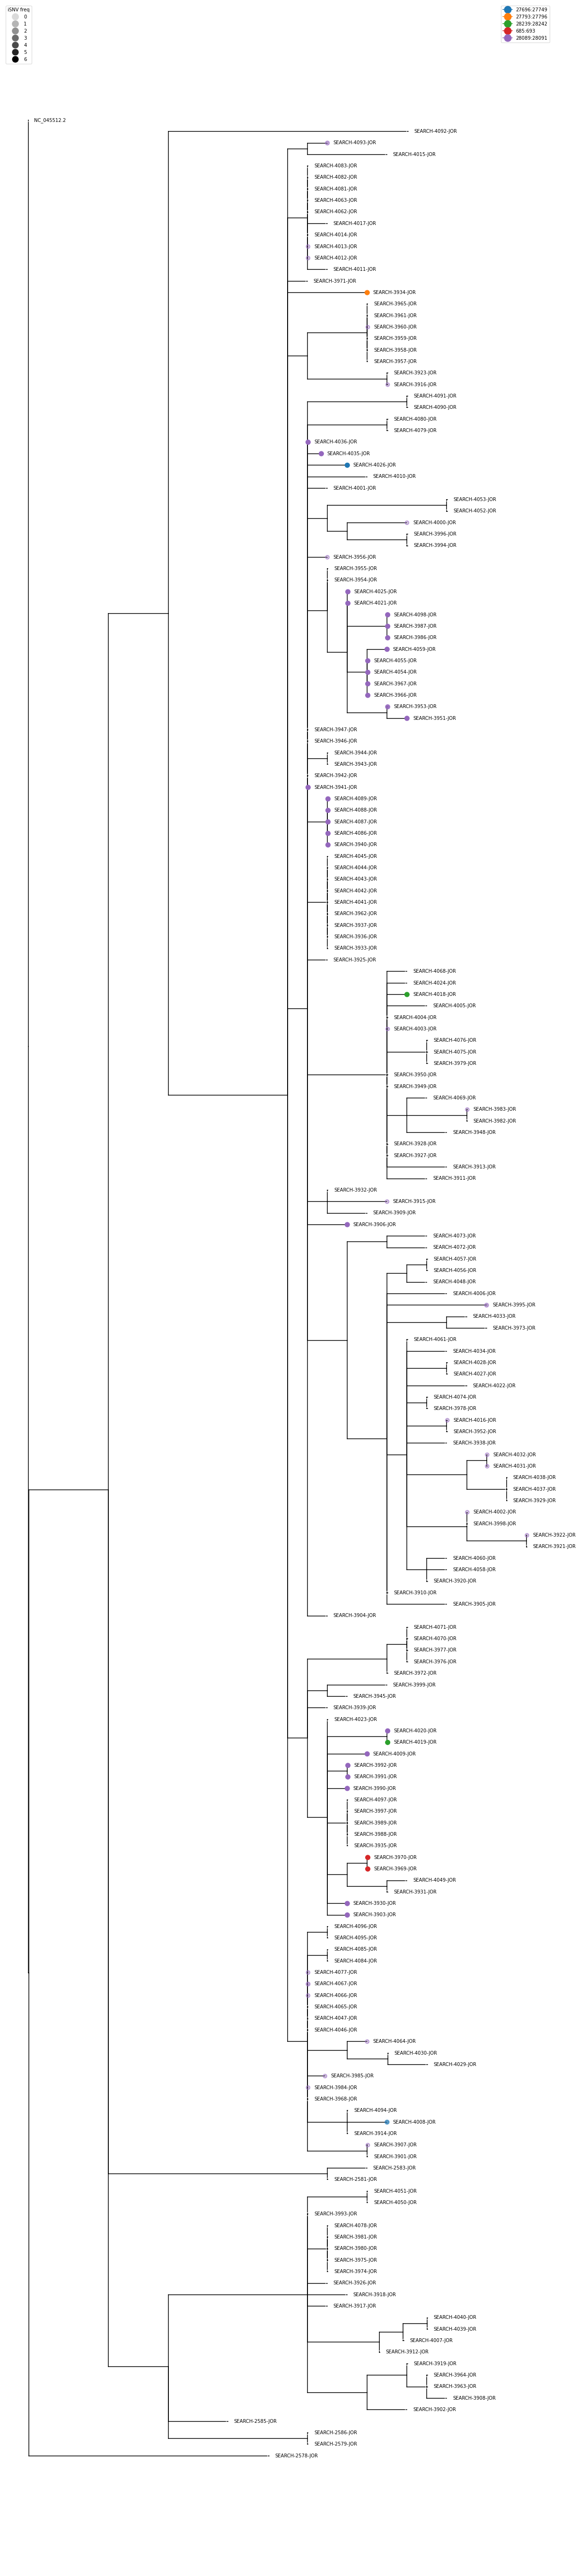

In [129]:
f = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.75], height_ratios = [0.5,0.5])

ax = plt.subplot(gs[:,0])
for i in tree.get_nonterminals():
    for j in i.clades:
#         if prune_clade(j, deletion_samples): continue
        _t = ax.plot([i.x, i.x], [i.y, j.y], ls='-', color="#000000", zorder = 1)
        _t = ax.plot([i.x, j.x], [j.y, j.y], ls='-', color="#000000", zorder = 1)
        
_ = {
    "x": [],
    "y": [],
    "c": [],
    "o": [],
}
for i in tree.get_terminals():
    _["x"].append(i.x)
    _["y"].append(i.y)
    _["c"].append(sample_colors.get(i.name, {'color': 'white'})['color'])
    _["o"].append(sample_colors.get(i.name, {'freq': 0.})['freq'])
    ax.text(i.x+1e-5, i.y-1e-1, i.name)
#     _["c"].append(c)
    # ax.text(i.x+0.001, i.y, i.name.split("_")[3])
    # if i.name in hp["taxon name"].tolist():
    #     ax.text(i.x + 0.000025, i.y, i.name.split("_")[0] + " " + str(hp[hp["taxon name"] == i.name]["#of homoplasic mutations"].values[0]))
# ax.text(_["x"], _["y"], _["text"])
_["co"] = generate_color_array(_["c"], _["o"])
ax.scatter(_["x"], _["y"], c = _["co"], s = 100, zorder = 2)#, edgecolors=_["c"])
ax.scatter(_["x"], _["y"], c = _["co"], s = 50, zorder = 2, edgecolors=_["c"])
dels_legend = ax.legend(handles=legend)
l = plt.gca().add_artist(dels_legend)
ax.legend(handles=isnv_legend, loc='upper left', title='iSNV freq')
f.patch.set_visible(False)
ax.axis('off')
plt.savefig('jordan_deletions.pdf', bbox_inches='tight')
plt.show()

In [130]:
jor_dels

,del_coords,del_len,samples,num_samples
0,27696:27749,54,['SEARCH-4026-JOR'],1
1,27793:27796,4,['SEARCH-3934-JOR'],1
2,28239:28242,4,"['SEARCH-4018-JOR', 'SEARCH-4019-JOR']",2
3,685:693,9,"['SEARCH-3969-JOR', 'SEARCH-3970-JOR']",2
4,28089:28091,3,"['SEARCH-3903-JOR', 'SEARCH-3906-JOR', 'SEARCH...",27
